In [1]:
from jax.config import config
config.update("jax_enable_x64", True)

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]=".4"

import time
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from copy import deepcopy

import jax
import jax.numpy as jnp
from jax import jit, lax, grad, value_and_grad, vmap
import optax
import distrax

from neuron import h
_ = h.load_file("stdlib.hoc")

from neurax.integrate import solve
from neurax.cell import Cell, _compute_num_kids, _compute_index_of_kid, compute_levels
from neurax.stimulus import Stimulus, step_current
from neurax.recording import Recording
from neurax.connection import Connection, Connectivity
from neurax.utils.plot_utils import plot_morph
from neurax.mechanisms.hh_neuron import hh_neuron_gate
from neurax.mechanisms.glutamate_synapse import glutamate

--No graphics will be displayed.


In [4]:
device_str = "cpu"
jax.config.update('jax_platform_name', device_str)

cpus = jax.devices("cpu")
gpus = jax.devices("gpu")

device = cpus[0] if device_str == "cpu" else gpus[0]

# Setup

### Define model

In [5]:
n_params_per_cell = 1

In [6]:
num_cells = 16
nseg_per_branch = 4
num_branches = 15
ncomp = num_branches * nseg_per_branch
parents = jnp.asarray([-1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6])

assert len(parents) == num_branches

# Initialize states
init_v = jnp.asarray([[-62.0] * num_branches*nseg_per_branch] * num_cells)
init_m = jnp.asarray([[0.074901] * num_branches*nseg_per_branch] * num_cells)
init_h = jnp.asarray([[0.4889] * num_branches*nseg_per_branch] * num_cells)
init_n = jnp.asarray([[0.3644787] * num_branches*nseg_per_branch] * num_cells)
hh_states = jnp.stack([init_m, init_h, init_n])

length = 100.0  # um (length of a single branch)
radius = 10.0  # um
r_a = 10_000  # ohm cm 
i_delay = 5.0  # ms
i_amp = 1.0  # nA
i_dur = 2.0  # ms
dt = 0.025  # ms
t_max = 15.0  # ms

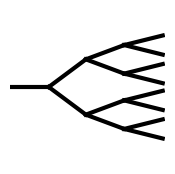

In [7]:
plot_morph(
    parents, 
    _compute_num_kids(parents), 
    _compute_index_of_kid(parents), 
    compute_levels(parents),
)
plt.savefig("../../results/morph.png", dpi=200, bbox_inches="tight")

### Set up model

In [8]:
time_vec = jnp.arange(0, t_max+dt, dt)

In [9]:
cells = [Cell(num_branches, parents, nseg_per_branch, length, radius, r_a)] * num_cells
recs = [
    Recording(15, 0, 0.0),
]
conns = []
for pre in jnp.arange(5):
    for post in jnp.arange(5, 15):
        conn = Connection(pre, 0, 0.0, post, 7+pre, 1.0)
        conns.append(conn)
for pre in jnp.arange(5, 10):
    for post in jnp.arange(15, 16):
        conn = Connection(pre, 0, 0.0, post, 2+pre, 1.0)
        conns.append(conn)
for pre in jnp.arange(10, 15):
    for post in jnp.arange(15, 16):
        conn = Connection(pre, 0, 0.0, post, -3+pre, 0.5)
        conns.append(conn)
        
connectivities = [Connectivity(conns, nseg_per_branch),]

### Parameter bounds

In [11]:
def sigmoid(x):
    return 1 / (1 + jnp.exp(-x))

def expit(x):
    return -jnp.log(1 / x - 1)

lower_gna = jnp.asarray([[0.08] * n_params_per_cell] * num_cells)
upper_gna = jnp.asarray([[0.16] * n_params_per_cell] * num_cells)

lower_gkd = jnp.asarray([[0.02] * n_params_per_cell] * num_cells)
upper_gkd = jnp.asarray([[0.05] * n_params_per_cell] * num_cells)

lower_gleak = jnp.asarray([[0.0002] * n_params_per_cell] * num_cells)
upper_gleak = jnp.asarray([[0.0004] * n_params_per_cell] * num_cells)

lower = jnp.stack([lower_gna, lower_gkd, lower_gleak])
upper = jnp.stack([upper_gna, upper_gkd, upper_gleak])

tf = distrax.Lambda(
    forward=lambda x: sigmoid(x) * (upper-lower) + lower, 
    inverse=lambda x: expit((x - lower) / (upper - lower))
)

lower_syn = jnp.asarray([0.6] * len(conns))
upper_syn = jnp.asarray([1.4] * len(conns))

tf_syn = distrax.Lambda(
    forward=lambda x: sigmoid(x) * (upper_syn-lower_syn) + lower_syn, 
    inverse=lambda x: expit((x - lower_syn) / (upper_syn - lower_syn))
)

### ODE

In [12]:
checkpoint_inds = []
def ode(diff_params, diff_syn_params, stim_traces):
    # Prepare params.
    diff_params = tf.forward(diff_params)
    
    # Repeat parameter for each compartment.
    hh_params = jnp.tile(diff_params, (1, 1, ncomp))
    
    # Transform synaptic params.
    synapse_params = tf_syn.forward(diff_syn_params)
    
    # Prepare stimuli.
    stims = [
        Stimulus(
            cell_ind=i, 
            branch_ind=0, 
            loc=0.0, 
            current=stim_traces[i]
        ) for i in range(5)
    ]
    
    mem_channels = [hh_neuron_gate,]
    mem_states = [hh_states,]
    mem_params = [hh_params,]

    syn_channels = [glutamate,]
    syn_states = [jnp.zeros((len(conns))),]
    syn_params = [synapse_params,]
    
    # Solve ODE.
    s = solve(
        cells,
        connectivities,
        init_v,
        mem_states=mem_states,
        mem_params=mem_params,
        mem_channels=mem_channels,
        syn_states=syn_states,
        syn_params=syn_params,
        syn_channels=syn_channels,
        stimuli=stims,
        recordings=recs,
        t_max=t_max,
        dt=dt,
        solver="stone",
        checkpoint_inds=checkpoint_inds
    )
    
    return s


def loss_fn(diff_params, diff_syn_params, stim_traces, target):
    s = ode(diff_params, diff_syn_params, stim_traces)
    voltage_at_last_time = s[0, -1]
    target_at_last_time = target[0, -1]
    return (voltage_at_last_time - target_at_last_time) ** 2

### Generate data

In [13]:
g_na = jnp.asarray([[0.12] * n_params_per_cell] * num_cells)
g_kd = jnp.asarray([[0.036] * n_params_per_cell] * num_cells)
g_leak = jnp.asarray([[0.0003] * n_params_per_cell] * num_cells)

theta_gt = tf.inverse(jnp.stack([g_na, g_kd, g_leak]))
synapse_gt = tf_syn.inverse(jnp.asarray([1.0] * len(conns)))

In [14]:
n_inputs = 5

n_batches = 10
batchsize = 4
n_train = n_batches * batchsize

np.random.seed(0)
stim_intensities = 2 * jnp.asarray(np.random.rand(n_train, n_inputs))

stims = jnp.asarray(
    [
        [
            stim_intensities[j, i] * step_current(i_delay, i_dur, i_amp, time_vec) for i in range(n_inputs)
        ] for j in range(n_train)
    ]
)
stims_in_batches = jnp.reshape(stims, (n_batches, batchsize, n_inputs, -1))

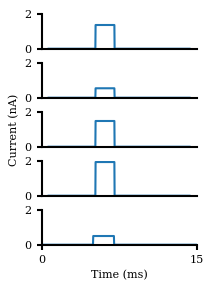

In [15]:
with mpl.rc_context(fname=".matplotlibrc"):
    fig, ax = plt.subplots(n_inputs, 1, figsize=(2, 3))
    for i in range(n_inputs):
        _ = ax[i].plot(time_vec, stims_in_batches[5, 0, i])
        ax[i].set_ylim([0, 2])
        ax[i].set_xlabel("")
        ax[i].set_xticks([])
    ax[n_inputs-1].set_xticks([0, max(time_vec)])
    ax[n_inputs-1].set_xlim([0, max(time_vec)])
    ax[n_inputs-1].set_xlabel("Time (ms)")
    ax[2].set_ylabel("Current (nA)")
    plt.subplots_adjust(hspace=0.4)
    plt.savefig("../../results/stimuli.png", dpi=200, bbox_inches="tight")

In [16]:
vmaped_ode = vmap(jit(ode), in_axes=(None, None, 0))

In [17]:
targets = []
for batch in stims_in_batches:
    start_time = time.time()
    results = vmaped_ode(
        theta_gt,
        synapse_gt,
        batch, 
    )
    print("Time:  ", time.time() - start_time)
    targets.append(results)
targets_in_batches = jnp.asarray(targets)

Time:   3.9596078395843506
Time:   0.21218299865722656
Time:   0.21402525901794434
Time:   0.2126462459564209
Time:   0.21198606491088867
Time:   0.21242642402648926
Time:   0.2128305435180664
Time:   0.21240663528442383
Time:   0.21233224868774414
Time:   0.21313881874084473


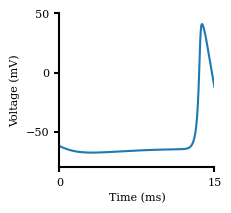

In [18]:
with mpl.rc_context(fname=".matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(2, 2))
    _ = ax.plot(time_vec, targets_in_batches[5, 0, 0])
    _ = ax.set_ylim([-80, 50])
    ax.set_xlabel("")
    ax.set_xticks([])
    ax.set_xticks([0, max(time_vec)])
    ax.set_xlim([0, max(time_vec)])
    ax.set_xlabel("Time (ms)")
    ax.set_ylabel("Voltage (mV)")
    plt.subplots_adjust(hspace=0.4)
#     plt.savefig("../../results/response.png", dpi=200, bbox_inches="tight")

### Compile grad

In [19]:
vmaped_grad = vmap(jit(value_and_grad(loss_fn, argnums=(0, 1))), in_axes=(None, None, 0, 0))

In [20]:
start_time = time.time()
loss, grad_val = vmaped_grad(
    theta_gt,
    synapse_gt,
    stims_in_batches[0],
    targets_in_batches[0],
)
print("Time:  ", time.time() - start_time)
print("loss", loss)

Time:   42.684728384017944
loss [8.86364113e-27 8.07793567e-26 5.04870979e-29 3.43627810e-27]


# Optimize

In [41]:
seed = 4
np.random.seed(seed)
params_membrane = jnp.asarray(np.random.rand(3, num_cells, n_params_per_cell) * (upper - lower) + lower)
params_syn = jnp.asarray(np.random.rand(len(conns)) * (upper_syn - lower_syn) + lower_syn)

In [42]:
theta_membrane = tf.inverse(params_membrane)
theta_syn = tf_syn.inverse(params_syn)

In [43]:
optimizer = optax.adam(learning_rate=5e-2)
opt_state = optimizer.init((theta_membrane, theta_syn))

In [44]:
all_epoch_losses = []
all_batch_losses = []
median_epoch_losses = []
num_iter = 15
for iter_ in range(num_iter):
    train_loss = 0.0
    train_losses = []
    for batch_stims, batch_targets in zip(stims_in_batches, targets_in_batches):
        loss, grad = vmaped_grad(
            theta_membrane,
            theta_syn,
            batch_stims,
            batch_targets,
        )
        loss = jnp.mean(loss, axis=0)
        train_losses.append(loss)
        train_loss += loss
        grad_membrane = jnp.mean(grad[0], axis=0)
        grad_synapse = jnp.mean(grad[1], axis=0)
        
        if jnp.any(jnp.isnan(grad_membrane)) or jnp.any(jnp.isnan(grad_synapse)):
            print(f"iter {iter_}, loss {loss}, ===== skipping")
            theta_membrane = theta_membrane.at[0, 0, 0].add(1e-3)
        else:
            print(f"iter {iter_}, loss {loss}")
            updates, opt_state = optimizer.update((grad_membrane, grad_synapse), opt_state)
            theta_membrane, theta_syn = optax.apply_updates((theta_membrane, theta_syn), updates)
            
        all_batch_losses.append(loss)
            
    print(f"=================== iter: {iter_}, Train loss: {train_loss}")
    all_epoch_losses.append(train_loss / n_batches)
    median_epoch_losses.append(np.median(train_losses))
    
    
final_membrane = tf.forward(theta_membrane)
final_syn = tf_syn.forward(theta_syn)

iter 0, loss 592.315277314795
iter 0, loss 516.3194004996274
iter 0, loss 869.0953328489119
iter 0, loss 408.16011636033716
iter 0, loss 274.810070524921
iter 0, loss 65.41772798141173
iter 0, loss 86.39470338229452
iter 0, loss 11.321322194822342
iter 0, loss 7.12211193520657
iter 0, loss 53.30683962488992
=================== iter: 0, Train loss: 2884.262902667218
iter 1, loss 14.811015245134373
iter 1, loss 12.503464837330721
iter 1, loss 4.267687989046693
iter 1, loss 523.7650586435257
iter 1, loss 84.43653293805001
iter 1, loss 61.42111036884583
iter 1, loss 65.6510534009159
iter 1, loss 117.47758855451576
iter 1, loss 108.65629476825157
iter 1, loss 83.46696942119921
=================== iter: 1, Train loss: 1076.4567761668156
iter 2, loss 92.12894671144505
iter 2, loss 65.19382311212104
iter 2, loss 59.63554669617753
iter 2, loss 645.4342572063966
iter 2, loss 88.09812633751693
iter 2, loss 26.303691041407035
iter 2, loss 21.93980445778437
iter 2, loss 32.42398346276633
iter 2, lo

In [45]:
x_epochs = np.arange(num_iter)
condition = np.invert(np.isnan(all_epoch_losses))
x_epochs = x_epochs[condition]
losses_to_plot = np.asarray(all_epoch_losses)[condition]
med_losses_to_plot = np.asarray(median_epoch_losses)[condition]

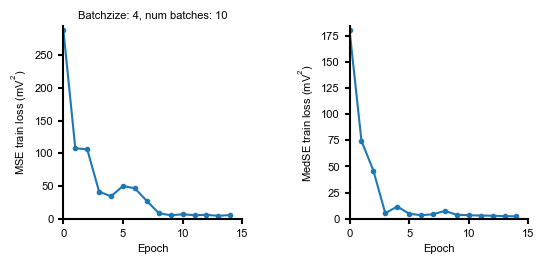

In [46]:
with mpl.rc_context(fname=".matplotlibrc"):
    fig, ax = plt.subplots(1, 2, figsize=(6, 2.5))
    _ = ax[0].plot(x_epochs, losses_to_plot)
    _ = ax[0].scatter(x_epochs, losses_to_plot)
    _ = ax[1].plot(x_epochs, med_losses_to_plot)
    _ = ax[1].scatter(x_epochs, med_losses_to_plot)
    for i in range(2):
        _ = ax[i].set_xlim([0, num_iter])
        _ = ax[i].set_xlabel("Epoch")
    _ = ax[0].set_ylim([0, max(losses_to_plot) * 1.02])
    _ = ax[1].set_ylim([0, max(med_losses_to_plot) * 1.02])
    _ = ax[0].set_ylabel(r"MSE train loss ($mV^2$)")
    _ = ax[1].set_ylabel(r"MedSE train loss ($mV^2$)")
    _ = ax[0].set_title(f"Batchzize: {batchsize}, num batches: {n_batches}")
    plt.subplots_adjust(wspace=0.6)
    plt.savefig(f"../../results/train_loss_bigger_range_seed_{seed}.png", dpi=200, bbox_inches="tight")
    plt.show()

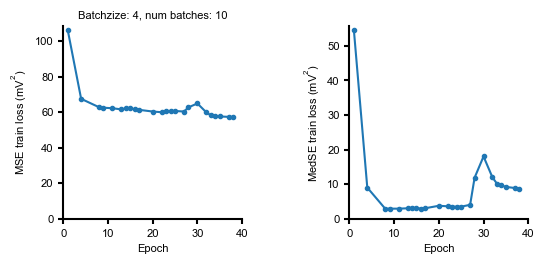

In [26]:
with mpl.rc_context(fname=".matplotlibrc"):
    fig, ax = plt.subplots(1, 2, figsize=(6, 2.5))
    _ = ax[0].plot(x_epochs, losses_to_plot)
    _ = ax[0].scatter(x_epochs, losses_to_plot)
    _ = ax[1].plot(x_epochs, med_losses_to_plot)
    _ = ax[1].scatter(x_epochs, med_losses_to_plot)
    for i in range(2):
        _ = ax[i].set_xlim([0, num_iter])
        _ = ax[i].set_xlabel("Epoch")
    _ = ax[0].set_ylim([0, max(losses_to_plot) * 1.02])
    _ = ax[1].set_ylim([0, max(med_losses_to_plot) * 1.02])
    _ = ax[0].set_ylabel(r"MSE train loss ($mV^2$)")
    _ = ax[1].set_ylabel(r"MedSE train loss ($mV^2$)")
    _ = ax[0].set_title(f"Batchzize: {batchsize}, num batches: {n_batches}")
    plt.subplots_adjust(wspace=0.6)
    plt.savefig(f"../../results/train_loss_bigger_range_seed_{seed}.png", dpi=200, bbox_inches="tight")
    plt.show()